In [32]:
import pandas as pd
import os, json, re
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [33]:
%%capture
!pip install catboost
!pip install xgboost
import xgboost as xgb
import catboost as cb

In [34]:
df = pd.read_csv("/kaggle/input/football-match-probability-prediction/train.csv")
df.fillna("", inplace=True)
print(len(df))

110938


In [35]:
df2 = pd.read_csv("/kaggle/input/football-match-probability-prediction/test.csv")
df2.fillna("", inplace=True)
print(len(df2))

72711


In [36]:
def remove_things(df, phase='train'):
    
    if phase == 'train':
        #If do not have value of day 1, then just delete the row
        df = df[df['home_team_history_match_date_1'] != ""]
        # There is just 1 row is_cup == "", so delete this row
        df = df[df['is_cup'] != ""]
    # in inference stage, there is no team name, so I remove this feature from beginning
    del df['home_team_name']
    del df['away_team_name']
    # there are so many NaN in home(away)_team_coach_id, so I decide to ignore these columns
    del df['home_team_coach_id']
    del df['away_team_coach_id']
    # I remove league_name too, since len(set(df2['league_name'].unique()) - set(df['league_name'].unique())) > 0
    del df['league_name']
    # I remove league_id too, since len(set(df2['league_id'].unique()) - set(df['league_id'].unique())) > 0
    del df['league_id']
    
    print(len(df))
    return df
df = remove_things(df, "train")
df2 = remove_things(df2, "test")

109778
72711


In [37]:
def processing(df, phase="train"):
    # Convert date to datetime obj
    for col in df.filter(regex='date', axis=1).columns:
        df[col] = pd.to_datetime(df[col])
    df['is_cup'] = df['is_cup'].astype('int32')
    func_to_int = lambda x: int(x) if x != "" else np.nan
    func_to_float = lambda x: float(x) if x != "" else np.nan
    for i in range(1, 11):
        for team in ["home", "away"]:
            for col in [f'{team}_team_history_is_play_home_{i}',
                        f'{team}_team_history_is_cup_{i}',
                        f'{team}_team_history_goal_{i}',
                        f'{team}_team_history_opponent_goal_{i}',
                        
                       ]:
                df[col] = df[col].apply(func_to_int)
            for col in [f'{team}_team_history_rating_{i}',
                        
                       ]:
                df[col] = df[col].apply(func_to_float)
    def norm_coach(values):
        norm_values = []
        value_to_norm_value = {}
        max_norm_value = -1
        for value in values:
            if value == "":
                norm_values.append(np.nan)
            else:
                if value in value_to_norm_value:
                    norm_values.append(value_to_norm_value[value])
                else:
                    max_norm_value += 1
                    value_to_norm_value[value] = max_norm_value
                    norm_values.append(int(value_to_norm_value[value]))
        return pd.Series(norm_values)

    for team in ["home", "away"]:
        norm_coach_columns = [f'{team}_change_coach_{i}' for i in range(1, 11)]
        coach_columns = [f'{team}_team_history_coach_{i}' for i in range(1, 11)]
        df[norm_coach_columns] = df[coach_columns].apply(lambda x: norm_coach(x.values), axis=1)
        for col in coach_columns:
            del df[col]
    print(len(df))
    return df
df  = processing(df, "train")
df2 = processing(df2, "test")


109778
72711


In [ ]:
# def get_time_features(df):
#     func_get_hour = lambda x: x.hour
#     func_get_weekday = lambda x: x.dayofweek
#     df['match_hour'] = df['match_date'].apply(func_get_hour)
#     df['match_weekday'] = df['match_date'].apply(func_get_weekday)
#     for i in range(1, 11):
#         for team in ['home', 'away']:
#             col = f'{team}_team_history_match_date_{i}'
#             new_col = f'{team}_team_history_match_hour_{i}'
#             df[new_col] = df[col].apply(func_get_hour)
#             new_col = f'{team}_team_history_match_weekday_{i}'
#             df[new_col] = df[col].apply(func_get_weekday)
#     return df
# df = get_time_features(df)
# df2 = get_time_features(df2)

In [38]:
def remove2(df):
    for col in df.columns:
        if "match_date" in col:
            del df[col]
    ids = df['id']
    del df['id']
    print(len(df))
    return df, ids
df, _ = remove2(df)
df2, df2_ids = remove2(df2)


109778
72711


In [39]:
y_train = df['target']
X_train = df.drop(['target'], axis=1)
X_test = df2

In [40]:
from sklearn.model_selection import train_test_split

classes = ['home', 'draw', 'away']
# df_train, df_valid = train_test_split(df, train_size=0.8, random_state=42)
# y_train = df_train['target'].apply(lambda x: classes.index(x))
# X_train = df_train.drop(['target'], axis=1)

# y_valid = df_valid['target'].apply(lambda x: classes.index(x))
# X_valid = df_valid.drop(['target'], axis=1)

y_train = df['target'].apply(lambda x: classes.index(x))
X_train = df.drop(['target'], axis=1)



In [ ]:
import optuna

In [41]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
)
model.fit(X_train, y_train, 
          #eval_set=(X_valid, y_valid), 
          verbose=True
         )

# import optuna
# from sklearn.metrics import accuracy_score
# def objective(trial):
#     param = {
# #         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
# #         "depth": trial.suggest_int("depth", 1, 12),
#         "iterations": 100,
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#         ),
#     }

#     if param["bootstrap_type"] == "Bayesian":
#         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif param["bootstrap_type"] == "Bernoulli":
#         param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     gbm = CatBoostClassifier(**param)

#     gbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
#             verbose=0, early_stopping_rounds=100)

#     y_pred = gbm.predict(X_valid)
#     accuracy = accuracy_score(y_valid, y_pred)
#     return accuracy
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)
# trial = study.best_trial
# model = CatBoostClassifier(**trial.params, verbose=False)
# model.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import log_loss
# print(log_loss(y_valid, model.predict_proba(X_valid) ))


In [42]:
result = model.predict_proba(X_test)
submit = pd.DataFrame({
    "id": df2_ids,
    "home": result[:, 0],
    "draw": result[:, 1],
    "away": result[:, 2]
})
submit.to_csv("/kaggle/working/submission.csv", index=False)

In [52]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()

In [57]:
feature_importances = feature_importances[feature_importances > 0]

In [61]:
# Most important features
feature_importances[-10:]

home_team_history_rating_6             1.817783
home_team_history_rating_7             1.825664
home_team_history_rating_1             1.850552
home_team_history_rating_3             1.875294
home_team_history_opponent_rating_2    1.879691
away_team_history_rating_2             2.188324
home_team_history_rating_5             2.348936
home_team_history_opponent_rating_1    2.669287
home_team_history_rating_2             2.816349
away_team_history_rating_1             2.839072
dtype: float64

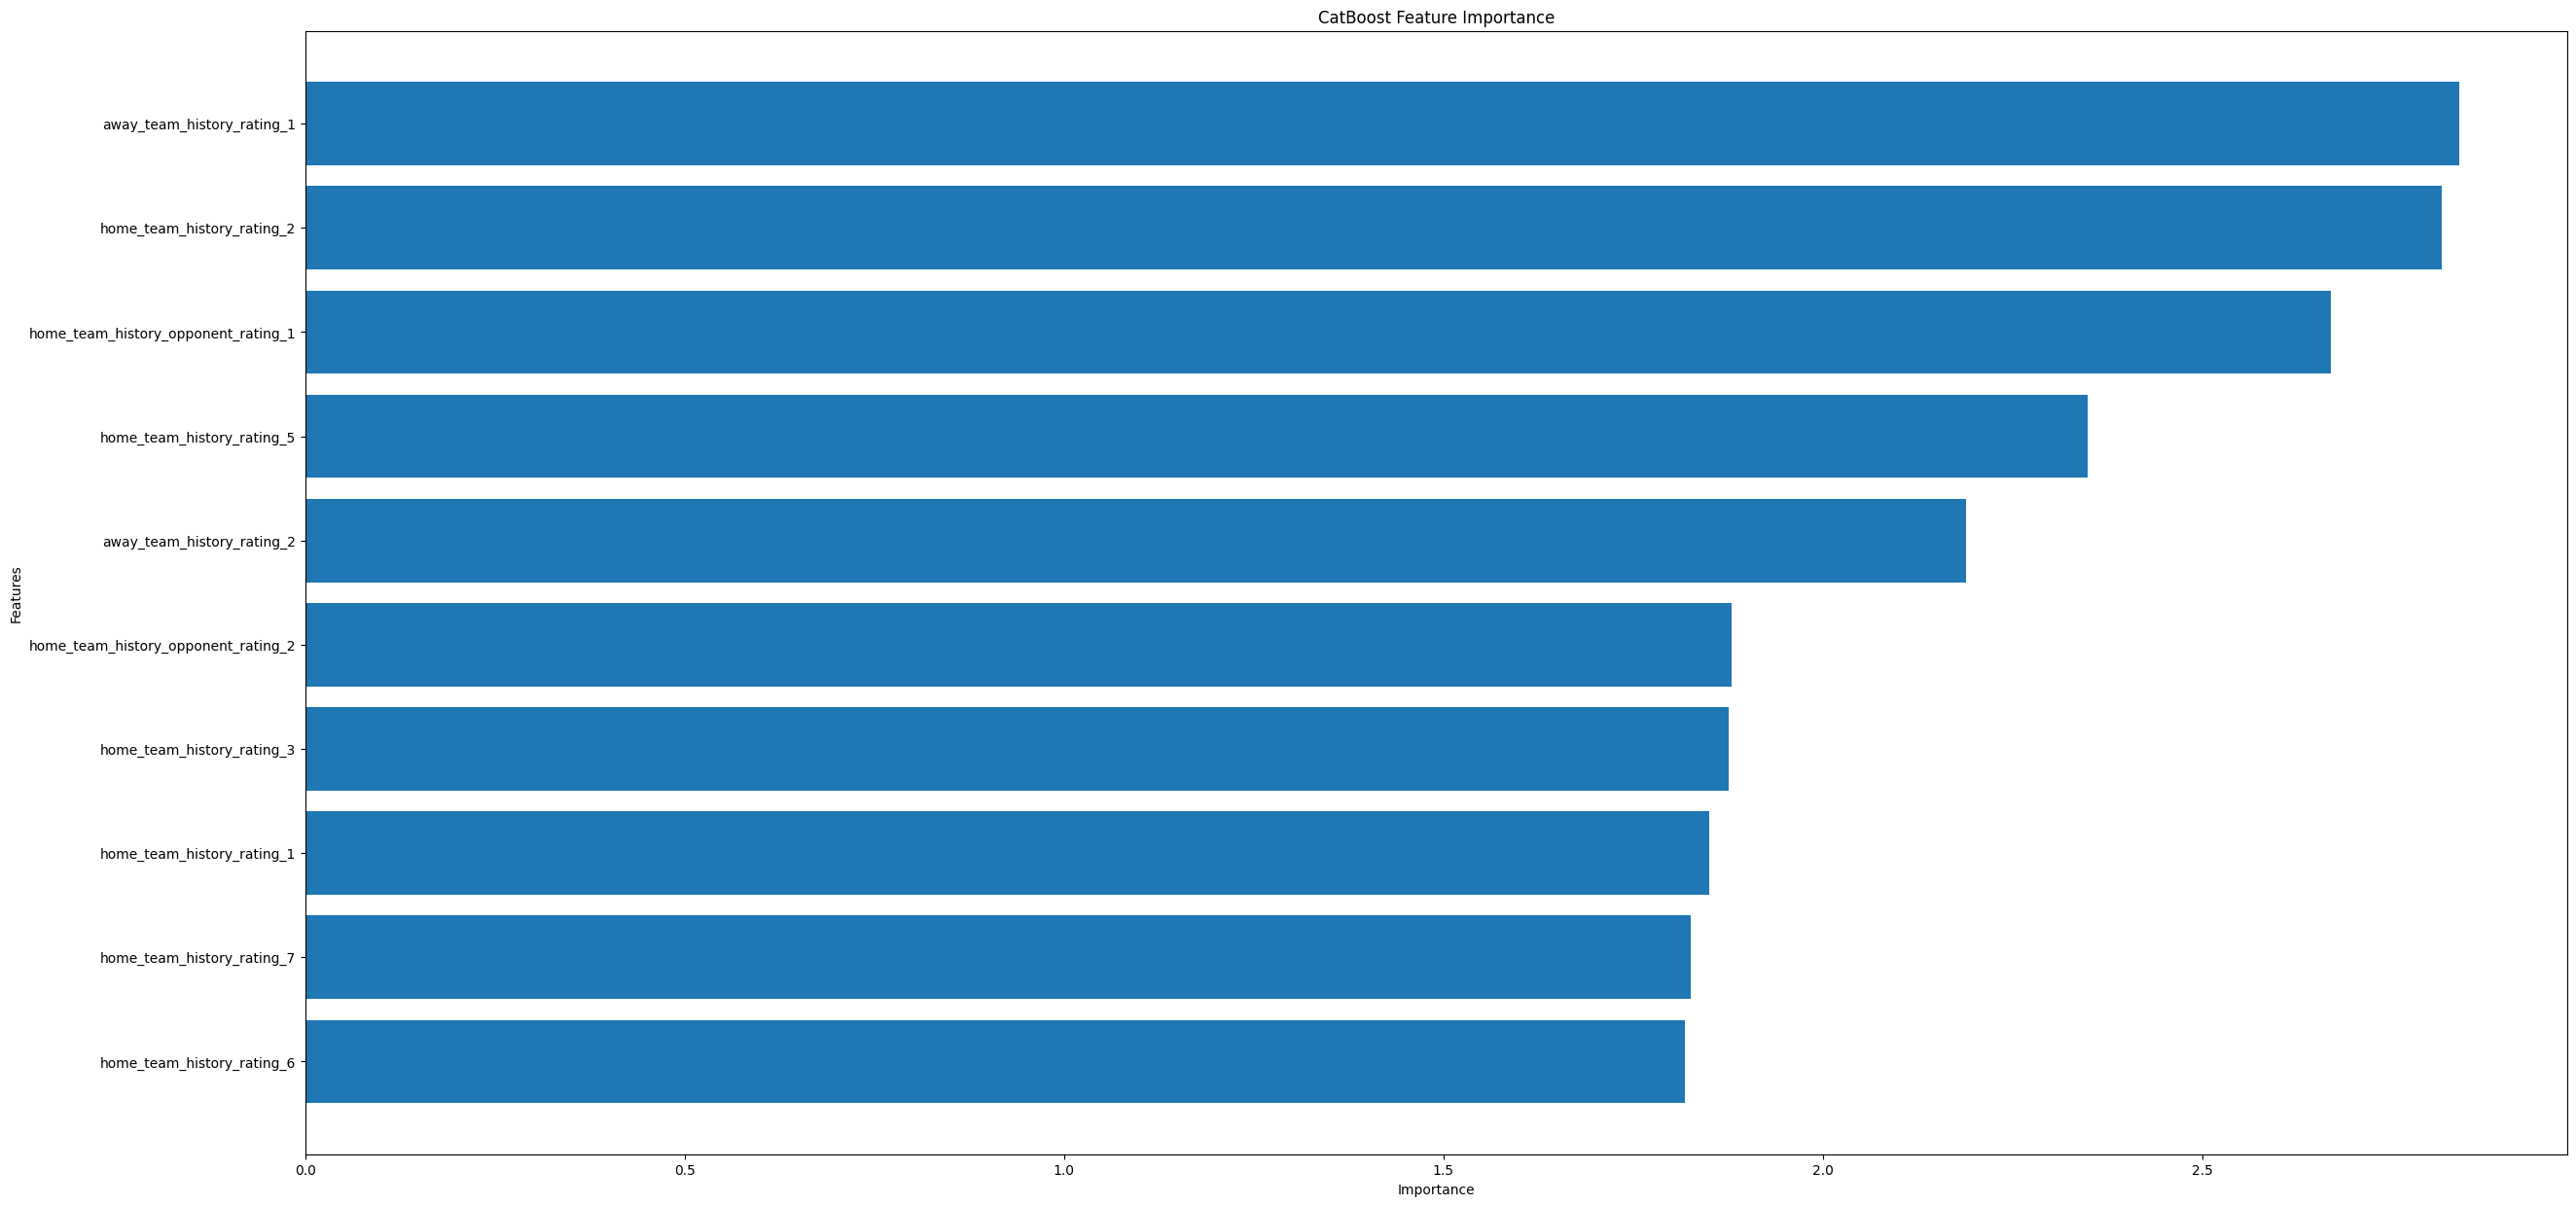

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 15))
plt.barh(feature_importances[-10:].index, feature_importances[-10:].values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()